In [4]:
import numpy as np
import os

# View dataset folder names under ../input
print("Datasets in ../input:")
print(os.listdir('../input'))

# Update this folder name to match your dataset's actual name
dataset_path = '/kaggle/input/27-class-sign-language-dataset'  

# View files in the dataset folder
print("Files in dataset:")
print(os.listdir(dataset_path))

# Load the .npy files
X = np.load(f'{dataset_path}/X.npy')
y = np.load(f'{dataset_path}/Y.npy')

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Datasets in ../input:
['27-class-sign-language-dataset']
Files in dataset:
['Y.npy', 'X.npy']
Shape of X: (22801, 128, 128, 3)
Shape of y: (22801, 1)


In [5]:
!pip install tensorflow


In [6]:
!pip install opencv-python # Install the opencv-python library, which provides the cv2 module.
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import cv2 # Now, the import should work as the module is installed.
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

2025-04-17 20:37:18.626133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744922238.821525      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744922238.874514      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


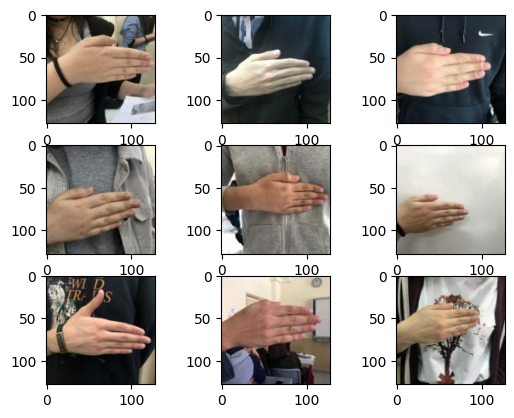

In [8]:
# prompt: print the images in the data

import matplotlib.pyplot as plt
import numpy as np

# Assuming X is your image data loaded from the .npy file
# and it's a NumPy array where each element is an image.


# Check if X is loaded correctly
if X is not None and isinstance(X, np.ndarray):
  # Display the first 9 images
  for i in range(9):
      plt.subplot(330 + 1 + i)
      plt.imshow(X[i])  # Assuming X[i] is an image
  plt.show()
else:
  print("Error: Image data (X) is not loaded or not in the correct format.")


In [9]:
def resize_images(images, target_size=(128,128)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)

X_resized = resize_images(X)

In [10]:
images = X.astype('float32')
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(y.reshape(-1))
y_categorical = to_categorical(labels)

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
X_train, X_val, y_train, y_val = train_test_split(
    X_resized, y_categorical, test_size=0.2, random_state=42
)
# Create generator for training
train_generator = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=32,
    shuffle=True
)

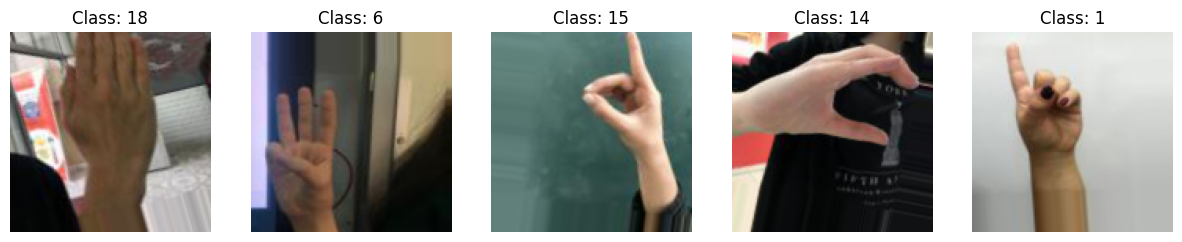

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(images, labels, num_samples=5, augmentation_type="Original"):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)

        # For grayscale images (single channel)
        if images[i].shape[-1] == 1:
            plt.imshow(images[i].squeeze(), cmap='gray')
        else:
            plt.imshow(images[i])

        plt.title(f"{augmentation_type}\nClass: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

# Generate a batch of augmented images
aug_images, aug_labels = next(train_generator)  # Correct syntax

# Plot samples
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)

    # For grayscale images (1 channel)
    if aug_images[i].shape[-1] == 1:
        plt.imshow(aug_images[i].squeeze(), cmap='gray')
    else:
        plt.imshow(aug_images[i])

    plt.title(f"Class: {np.argmax(aug_labels[i])}")
    plt.axis('off')
plt.show()

In [13]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)
base_model.trainable = False  # Freeze pre-trained layers

I0000 00:00:1744922295.626989      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744922295.627632      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(27, activation='softmax')  
])

In [15]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

In [19]:
import tensorflow as tf
history = model.fit(
    train_generator,
    validation_data=(X_val,y_val),
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 81s 140ms/step - Precision: 0.6997 - Recall: 0.2726 - accuracy: 0.4504 - loss: 1.7282 - val_Precision: 0.8094 - val_Recall: 0.4422 - val_accuracy: 0.6071 - val_loss: 1.1413
Epoch 2/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 75s 129ms/step - Precision: 0.7203 - Recall: 0.2971 - accuracy: 0.4668 - loss: 1.6706 - val_Precision: 0.8357 - val_Recall: 0.4839 - val_accuracy: 0.6481 - val_loss: 1.0635
Epoch 3/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 74s 129ms/step - Precision: 0.7279 - Recall: 0.3186 - accuracy: 0.4840 - loss: 1.5969 - val_Precision: 0.8371 - val_Recall: 0.5060 - val_accuracy: 0.6586 - val_loss: 1.0101
Epoch 4/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 74s 129ms/step - Precision: 0.7300 - Recall: 0.3312 - accuracy: 0.4982 - loss: 1.5595 - val_Precision: 0.8492 - val_Recall: 0.5161 - val_accuracy: 0.6683 - val_loss: 0.9966
Epoch 5/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 74s 128ms/step - Precision: 0.7331 - Recall: 0.3370 - accuracy: 0.5020 - loss: 1.5421 - val_Precision: 0.861

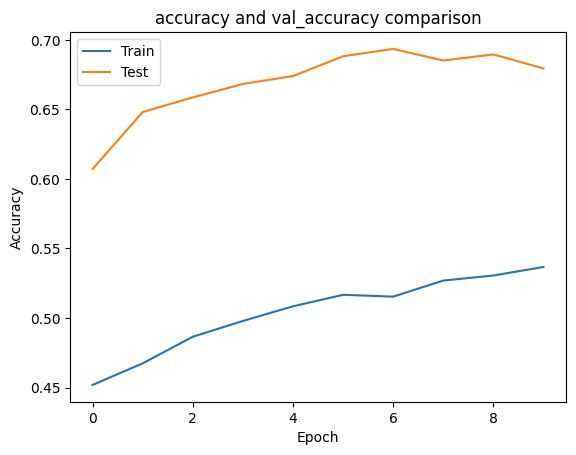

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy and val_accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()